GLM weighting
=======================

In [2]:
%reset -f
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from nilearn import plotting

from nilearn.connectome import ConnectivityMeasure
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_design_matrix

import seaborn as sns
sns.reset_orig()

from glob import glob
import scipy.io
import scipy.io as sio

from fctools import denoise

/home/finc/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading data
--------------------

In [3]:
top_dir = '/media/finc/Elements/LearningBrain_conn/LB_conn_dualnback_fmriprep/results/firstlevel/SBC_01/'
static = sorted(glob(top_dir + 'resultsROI_Condition013.mat'))

nilearn = np.load('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/LearningBrain_dualnback_timeseries_12par_conn_style_filt_after.npy')
conn = scipy.io.loadmat(static[0])
conn = conn['Z'][:264, :264, :]
conn_m = conn.mean(axis = 2)
np.fill_diagonal(conn_m, 0)


Whitfield-Gabrieli and Alfonso Nieto-Castanon (2012):
*The toolbox also allows condition-dependent functional connectivity analysis of block design studies, such as fcMRI analysis of interleaved resting periods or analysis of functional connectivity within task blocks.* 

Step 1.
-------------
"*In these cases and after the **session-specific treatment of temporal confounds, the BOLD time series is divided into scans associated with each blocked presentation**."*

/home/finc/anaconda/lib/python3.6/site-packages/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


(-0.4, 1.5)

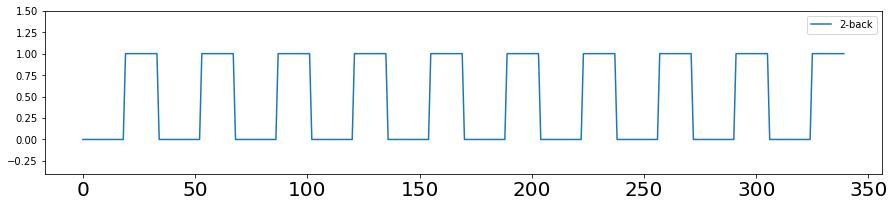

In [15]:
t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv'

events = pd.read_csv(onsets_dir)

frame_times = np.arange(n_scans) * t_r

#------ step 1
box = make_design_matrix(frame_times, events, hrf_model = None)
box = box.reset_index()

plt.figure(figsize = (15, 3))
plt.plot(box['2-back'])
plt.legend(['2-back'])
plt.ylim(ymin = -0.4, ymax = 1.5) 

Step 2.
--------

"*To take into account the hemodynamic delay, **block regressors for each condition are convolved with a canonical hemodynamic response function**, a combination of two gamma functions.*"

(-0.4, 1.5)

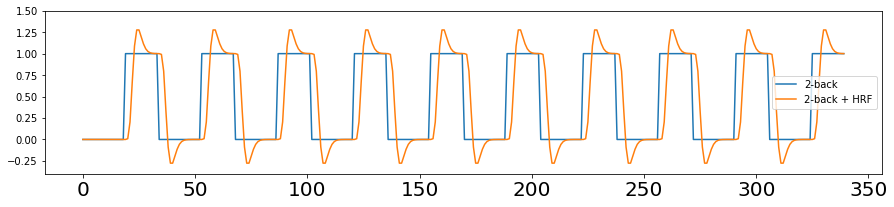

In [14]:
box_hrf = make_design_matrix(frame_times, events, hrf_model = 'glover')
box_hrf  = box_hrf.reset_index()

plt.figure(figsize = (15, 3))
plt.plot(box['2-back'])
plt.plot(box_hrf['2-back'])
plt.legend(['2-back','2-back + HRF'])
plt.ylim(ymin = -0.4, ymax = 1.5) 

Step 3.
--------
*"... and **rectified** {filtered to keep the positive part of the original time series; y[n] = max(0,x[n])}."*

(-0.4, 1.5)

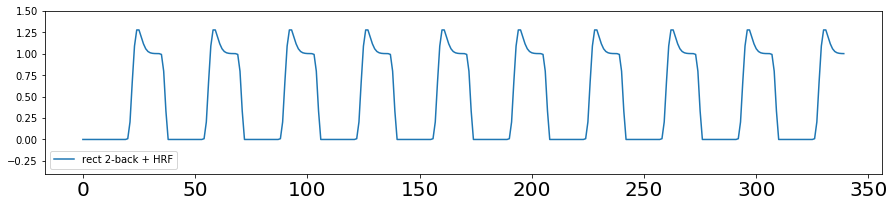

In [17]:
rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf['2-back']])
plt.figure(figsize = (15, 3))
#plt.plot(box['2-back'])
plt.plot(rect_box_hrf)

plt.legend(['rect 2-back + HRF'])
plt.ylim(ymin = -0.4, ymax = 1.5) 

Step 3.
--------
"*All of the scans with nonzero effects in the resulting time series are concatenated for each condition and across all sessions, weighting each scan by the value of these time series.*"

(-0.4, 1.5)

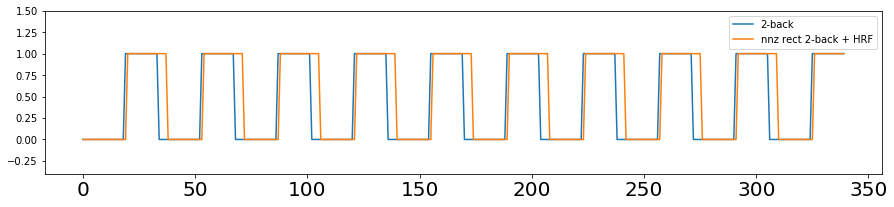

In [19]:
plt.figure(figsize = (15, 3))
plt.plot(box['2-back'])
plt.plot(box_hrf['2-back'] > 0)
plt.legend(['2-back', 'nnz rect 2-back + HRF'])
plt.ylim(ymin = -0.4, ymax = 1.5) 

(-0.4, 1.5)

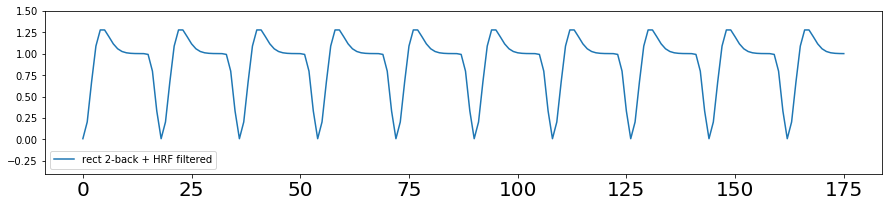

In [21]:
rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
plt.figure(figsize = (15, 3))
plt.plot(rect_nnz)
plt.legend(['rect 2-back + HRF filtered'])

plt.ylim(ymin = -0.4, ymax = 1.5) 


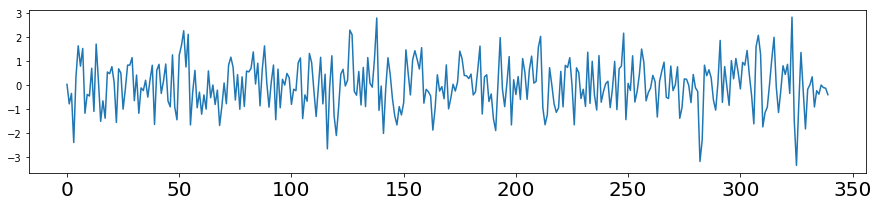

In [22]:
# --- example timeserie
plt.figure(figsize = (15, 3))
plt.plot(nilearn[0,0,:,0])

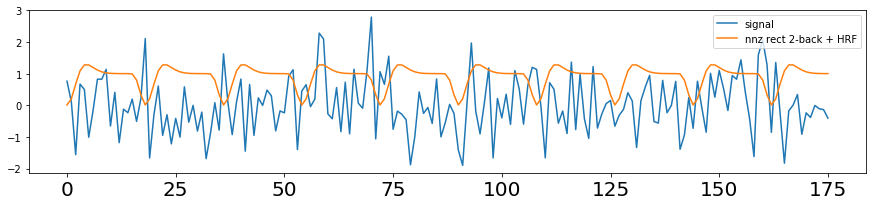

In [25]:
timeserie_2back = nilearn[0,0,np.nonzero(rect_box_hrf),0]
timeserie_2back.shape

plt.figure(figsize = (15, 3))
plt.plot(timeserie_2back[0,:])

plt.plot(rect_nnz)
plt.legend(['signal', 'nnz rect 2-back + HRF'])
